In [2]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [3]:
from pyTVDN import TVDNDetect
from pathlib import Path
import rpy2.robjects as robj
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
resDir = Path("./demoResults")

I load data here, the fMRI data are simulated.

In [5]:
robj.r["load"]("/home/huaqingj/MyResearch/TVDN/demo/demoData/dataMat_Nsim50_Chg3_rank6_len180.RData")
fMRI = np.array(robj.r["datamatrix"][0])

## Construct the TVDN Detection Class


- `saveDir` is the path to save the results, if upspecified, the results will not be saved.

- You can also specify the detection parameters manunally

In [6]:
kappa = 1.53
lamb = 1e-6
r = 6
Lmin = 10
fct = 2
nsim = 50

In [7]:
fMRIdet = TVDNDetect(Ymat=fMRI, saveDir=None, dataType="fMRI", fName="fMRIsample_", 
                     r=6, kappa=1.576, fct=2, lamb=1e-6, downRate=4, MaxM=10, Lmin=10, freq=0.5)

The parameters for detection are:
{'Lmin': 10,
 'MaxM': 10,
 'T': 2,
 'decimateRate': None,
 'downRate': 4,
 'fName': 'fMRIsample_',
 'fct': 2,
 'freq': 0.5,
 'is_detrend': False,
 'kappa': 1.576,
 'lamb': 1e-06,
 'nKnots': None,
 'nbasis': 10,
 'r': 6}


## Run the Main Function

In [8]:
fMRIdet()

Dynamic Programming: 100%|██████████| 180/180 [00:03<00:00, 52.64it/s]


### Check the current results

In [8]:
print(fMRIdet)

+-------------+----------------+--------------------+------+
| Num of CPTs | Estiamted CPTs |        MSE         | Rank |
+-------------+----------------+--------------------+------+
|      3      | [ 32 109 148]  | 1.5603901298542329 |  6   |
+-------------+----------------+--------------------+------+


## Tuning the kappa parameters

In [9]:
kappas = np.linspace(1.45, 2, 100)
#kappas = [1.45, 1.55, 1.65, 1.75, 1.85, 1.95]
fMRIdet.TuningKappa(kappas)

Kappa Tuning: 100%|██████████| 11/11 [00:01<00:00,  8.21it/s]


### Then we  can check the best kappa parameters w.r.t mean square errors

In [10]:
print("The optimal kappas are:", fMRIdet.optKappa)
print("The optimal number of change point under the range of kappa we speicified is:", fMRIdet.optKappaOptNumChg)
print("The optimal number of change point is:", fMRIdet.optNumChg)

The optimal kappas are: 1.45
The optimal number of change point under the range of kappa we speicified is: 4
The optimal number of change point is: 0


###  Update the estimated change point set based on optimal kappa

You can also specify the number of change points you want via provide the argument `numChg`, then the `UpdateEcpts` will update the current estimated change point set accordingly.

In such case, the `PlotXXX` function will plot the curves under the number of change point you provided

In [11]:
fMRIdet.UpdateEcpts(numChg=3)

In [12]:
print(fMRIdet)

+-------------+------------------+--------------------+------+
| Num of CPTs |  Estiamted CPTs  |        MSE         | Rank |
+-------------+------------------+--------------------+------+
|      3      | [ 32. 109. 148.] | 1.5603901298542329 |  6   |
+-------------+------------------+--------------------+------+


In [13]:
fMRIdet.UpdateEcpts()

In [14]:
print(fMRIdet)

+-------------+-----------------------+--------------------+------+
| Num of CPTs |     Estiamted CPTs    |        MSE         | Rank |
+-------------+-----------------------+--------------------+------+
|      4      | [ 32. 108. 125. 148.] | 1.5383655415648392 |  6   |
+-------------+-----------------------+--------------------+------+


### Plot the detection results 

 You may also specify the `saveFigPath` to save the figure


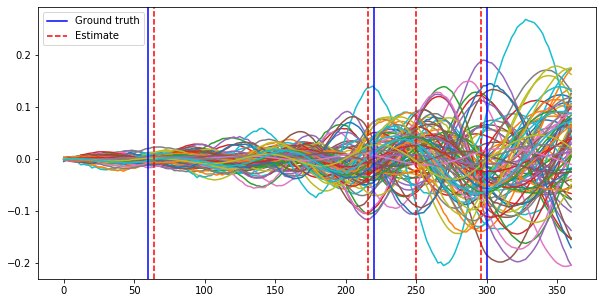

In [15]:
fMRIdet.PlotEcpts(GT=[30, 110, 150], saveFigPath=resDir/"fMRIecpt.jpg")

### Plot the reconstructed curve

 Similarly, you can specify the `saveFigPath` to save the figure
 
 You should specify the subsets of sequences you want to plot 
 - `idxs`: the indices of seqs to plot
 - `bestK`: The best `K` fitted curves

If you set `is_smoothCurve=True`, then it will plot the data after Bspline smoothing

The plot indices are [13  7 89].


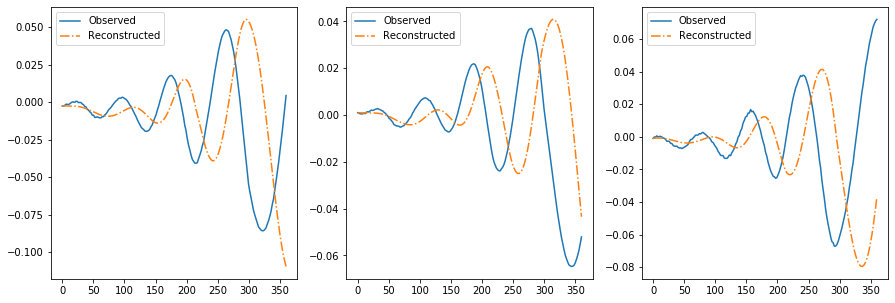

array([13,  7, 89])

In [16]:
fMRIdet.PlotRecCurve(bestK=3, saveFigPath=None)

The plot indices are [13, 7, 89].


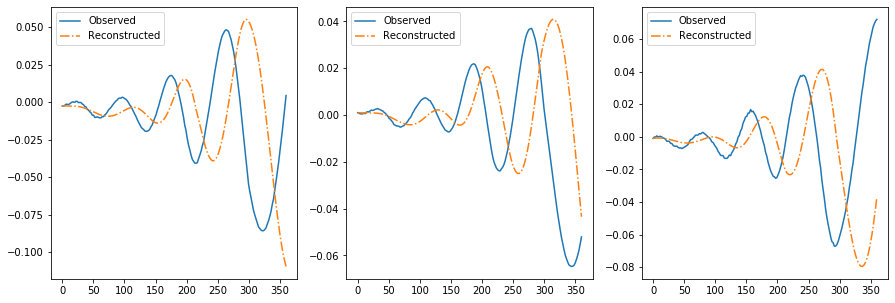

[13, 7, 89]

In [17]:
fMRIdet.PlotRecCurve(idxs=[13, 7, 89], saveFigPath=None)

The plot indices are [13, 7, 89].


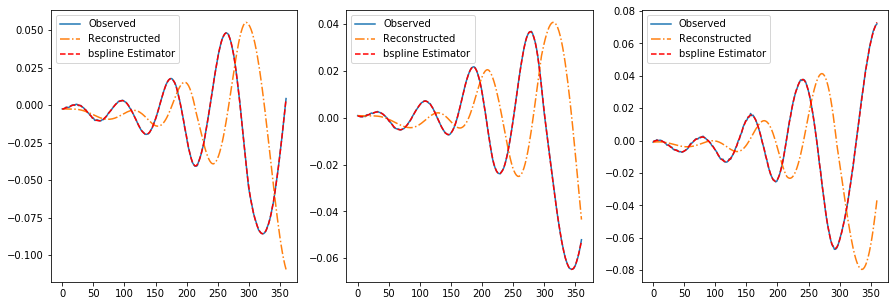

[13, 7, 89]

In [18]:
fMRIdet.PlotRecCurve(idxs=[13, 7, 89], saveFigPath=None, is_smoothCurve=True)

### Plot the eigenvalue curve

 Similarly, you can specify the `saveFigPath` to save the figure

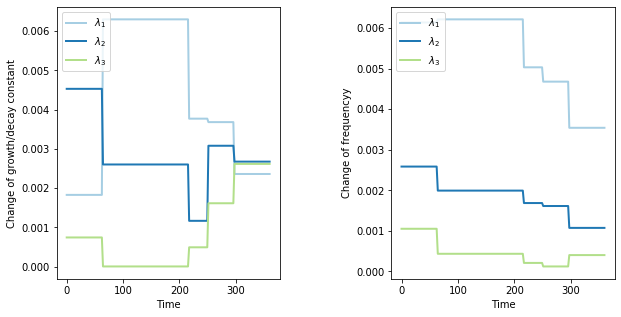

In [19]:
fMRIdet.PlotEigenCurve()

## Extract the Eigvals and EigVectors

The spatial features, i.e., the first `r` eigen vectors

In [20]:
r = fMRIdet.paras.r
U = fMRIdet.midRes.eigVecs
Ur = U[:, :r]

The temporal feaures, i.e., the eigen values for each segment

In [21]:
LamMs = fMRIdet.RecResCur.LamMs
ecpts = fMRIdet.ecpts
lamMs = []
for idx, ecpt in enumerate(np.concatenate([[0], ecpts])):
    lamM = LamMs[:, int(ecpt)]
    lamMs.append(lamM)

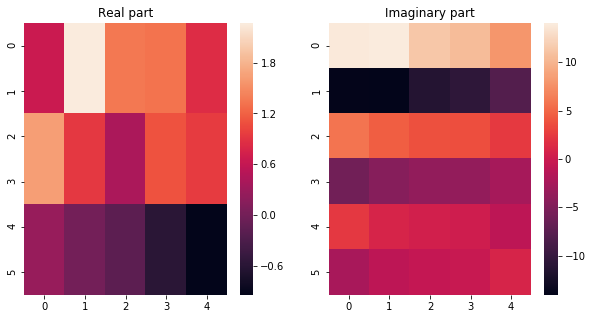

In [22]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title("Real part")
sns.heatmap(np.array(lamMs).real.T)
plt.subplot(122)
plt.title("Imaginary part")
sns.heatmap(np.array(lamMs).imag.T)

### Change the number of change point

In [23]:
fMRIdet.UpdateEcpts(3) # Reconstruct the Xmat and estiamte the eigen values, again

In [24]:
LamMs = fMRIdet.RecResCur.LamMs
ecpts = fMRIdet.ecpts
lamMs = []
for idx, ecpt in enumerate(np.concatenate([[0], ecpts])):
    lamM = LamMs[:, int(ecpt)]
    lamMs.append(lamM)

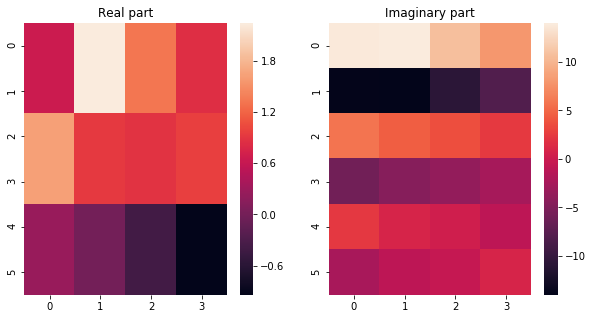

In [25]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.title("Real part")
sns.heatmap(np.array(lamMs).real.T)
plt.subplot(122)
plt.title("Imaginary part")
sns.heatmap(np.array(lamMs).imag.T)